In [1]:
%matplotlib inline
from pylab import *
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from treatment_sims_2023_02_21 import *

Splikes version  0.1.2
Plasticnet version  0.1.9
macOS-10.16-x86_64-i386-64bit


In [3]:
base='sims/2023-03-01'
if not os.path.exists(base):
    print(f"mkdir {base}")
    os.mkdir(base)

In [4]:
def mydisplay(t,sim,neurons,connections):
    global _fig
    from IPython.display import display, clear_output
    from pylab import figure,close,gcf,imshow,subplot,plot

    c=connections[0]

    weights=c.weights
    num_neurons=len(weights)
    rf_size=neurons[0][0].rf_size
    num_channels=len(neurons[0])

    W=weights.reshape((num_neurons,
                        num_channels,
                        rf_size,rf_size))

    vmin,vmax=W.min(),W.max()

    W=(W-vmin)/(vmax-vmin)

    blocks=[]
    for row in range(num_neurons):

        block_row=[]
        for col in range(num_channels):
            rf=W[row,col,:,:]
            block_row.append(rf)
            if col<num_channels-1:
                block_row.append(vmax*ones((rf_size,1)))
        blocks.append(block_row)

        if row<num_neurons-1:
            block_row=[]
            for col in range(num_channels):
                rf=W[row,col,:,:]
                block_row.append(vmax*ones((2,rf_size)))
                if col<num_channels-1:
                    block_row.append(vmax*ones((2,1)))
            blocks.append(block_row)


    

    im=np.block(blocks)

    t,θ=sim.monitors['theta'].arrays()

    try:
        clear_output(wait=True)
    
        _fig=figure(1)
        
        subplot(1,2,1)
        imshow(im,cmap=cm.gray)
        subplot(2,2,2)
        plot(t,θ)
        subplot(2,2,4)
        
        try:
            pp=sim.post_process[0]
            t=pp.t
            y=pn.utils.max_channel_response(pp.responses)
            y=y.transpose([2,1,0]) 
            plot(t,y[:,:,0],'m-')
            plot(t,y[:,:,1],'b-')        
        except AttributeError:
            pass
        
        _fig.canvas.draw_idle()
        display(_fig)
        close(_fig)
    except KeyboardInterrupt:
        close(_fig)
        raise
        

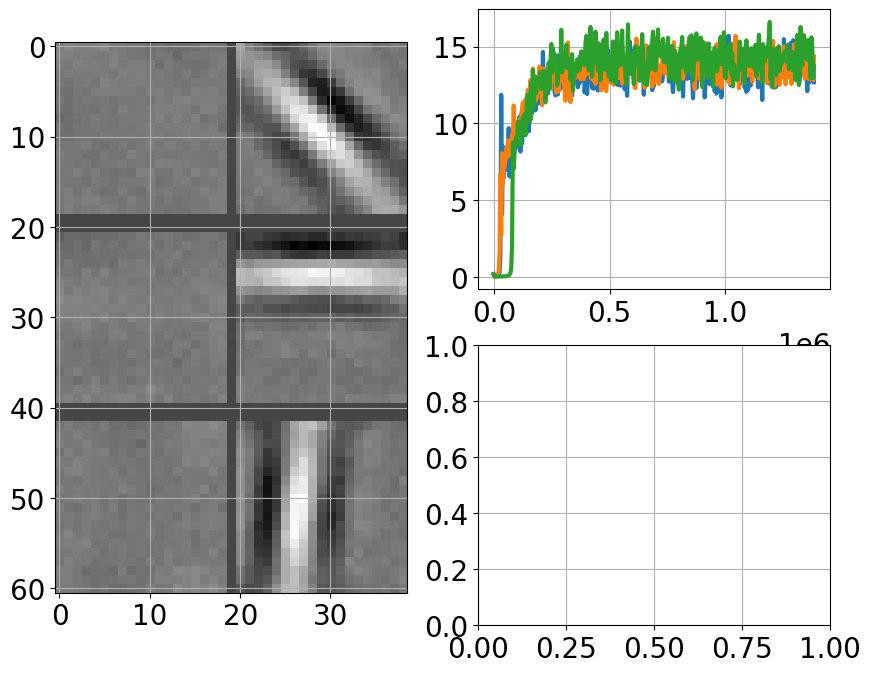

.] Sequence Time Elapsed...5 m, 16.95 s


In [5]:
rf_size=19
eta=2e-6
blur=6
number_of_neurons=3
number_of_processes=4
mu_c=7.5
sigma_c=2
mu_r=0
sigma_r=0
noise=1

sfname=f'{base}/deficit {number_of_neurons} neurons {blur} blur {mu_c} mu_c {sigma_c} sigma_c.asdf'



seq=pn.Sequence()

total_time=16*day
save_interval=1*hour

base_image_file='asdf/bbsk081604_all.asdf'
    
images=[]
dt=200*ms

for bv in [blur,-1]:
    if bv<=0:
        im=pi5.filtered_images(
                            base_image_file,
                            {'type':'dog','sd1':1,'sd2':3},
                            {'type':'norm'},
                            )
    else:
        im=pi5.filtered_images(
                                base_image_file,
                                {'type':'blur','size':bv},
                                {'type':'dog','sd1':1,'sd2':3},
                                {'type':'norm'},
                                )
    images.append(im)
    
    
dt=200*ms        
pre1=pn.neurons.natural_images_with_jitter(images[0],
                                            rf_size=rf_size,
                                            time_between_patterns=dt,
                                            sigma_r=1,
                                            sigma_c=1,
                                            verbose=False)

pre2=pn.neurons.natural_images_with_jitter(images[1],
                                            rf_size=rf_size,
                                            other_channel=pre1,
                                            time_between_patterns=dt,
                                            mu_r=mu_r,mu_c=mu_c,
                                            sigma_r=sigma_r,sigma_c=sigma_c,
                                            verbose=False)



sigma=noise
pre1+=pn.neurons.process.add_noise_normal(0,sigma)

sigma=noise
pre2+=pn.neurons.process.add_noise_normal(0,sigma)

pre=pre1+pre2

post=default_post(number_of_neurons)
c=default_bcm(pre,post)
c.eta=eta

sim=pn.simulation(total_time)
sim.dt=dt

sim.monitor(post,['output'],save_interval)
sim.monitor(c,['weights','theta'],save_interval)
sim+=pn.grating_response(print_time=False)



seq+=sim,[pre,post],[c]


seq.run(display=mydisplay,display_hash=False,
               time_between_display=save_interval)


pn.save(sfname,seq) 



In [9]:
pp=sim.post_process[0]

In [10]:
R=Results(sfname)

In [11]:
sfname

'sims/2023-03-01/deficit 3 neurons 6 blur 7.5 mu_c 2 sigma_c.asdf'

In [12]:
t,y=R.get_max_responses()
t=t[0]
y=y[0]

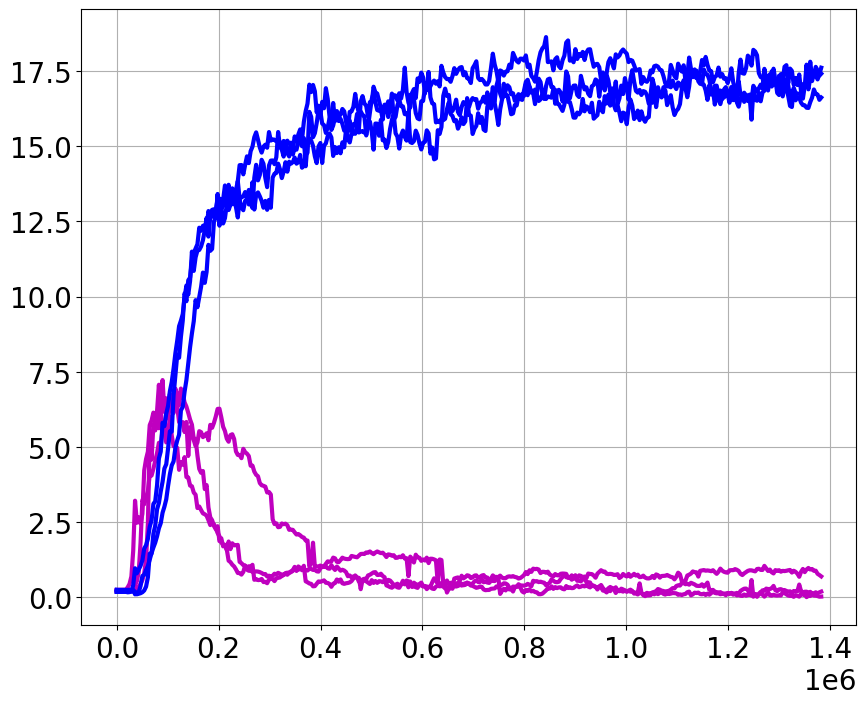

In [13]:
plot(t,y[:,:,0],'m-')
plot(t,y[:,:,1],'b-')

In [14]:
def run_one_continuous_fix_jitter(params,
                                  overwrite=False):
    import plasticnet as pn
    count,eta,noise,mu_c,sigma_c,number_of_neurons,sfname=(params.count,params.eta,params.noise,
                        params.mu_c,params.sigma_c,params.number_of_neurons,params.sfname)
    
    if not overwrite and os.path.exists(sfname):
        return sfname
    
    
    deficit_base_sim='sims/2023-03-01/deficit 3 neurons 6 blur 7.5 mu_c 2 sigma_c.asdf'

    seq=pn.Sequence()
    
    seq+=fix_jitter(total_time=100*hour,
             save_interval=20*minute,number_of_neurons=params.number_of_neurons,
            mu_c=mu_c,sigma_c=sigma_c,
             eta=eta,noise=noise)
    seq_load(seq,deficit_base_sim)    

    seq.run(display_hash=False)
    pn.save(sfname,seq) 
    
    return sfname
    

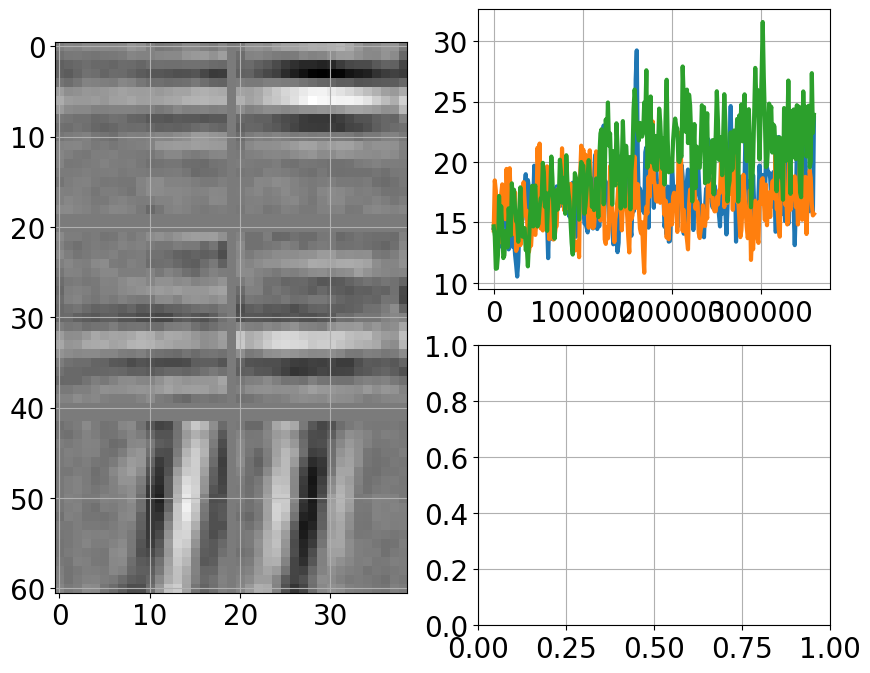

.] Sequence Time Elapsed...46.59 s


In [20]:
deficit_base_sim=sfname

seq=pn.Sequence()

noise=0.0

seq+=fix_jitter(total_time=100*hour,
         save_interval=20*minute,number_of_neurons=number_of_neurons,
        mu_c=mu_c,sigma_c=sigma_c,
         eta=eta,noise=noise)
seq_load(seq,deficit_base_sim)    

seq.run(display=mydisplay,display_hash=False,
               time_between_display=save_interval)

In [21]:
pp=seq[0][0].post_process[0]

In [22]:
pp.responses.shape

(20, 24, 2, 3, 301)

In [23]:
t=pp.t
y=pn.utils.max_channel_response(pp.responses)
y=y.transpose([2,1,0]) 
y.shape

(301, 3, 2)

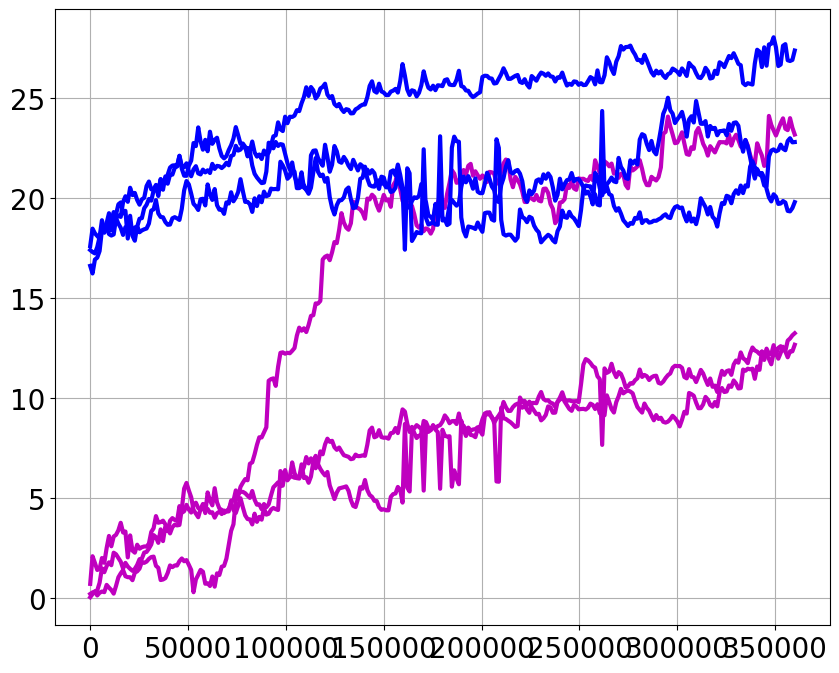

In [24]:
plot(t,y[:,:,0],'m-')
plot(t,y[:,:,1],'b-')

In [26]:
mu_c,sigma_c

(7.5, 2)

## patch

In [27]:
def run_one_continuous_patch_treatment_jitter(params,
                                  overwrite=False):
    import plasticnet as pn
    count,eta,noise,mu_c,sigma_c,number_of_neurons,sfname=(params.count,params.eta,
                                                           params.noise,params.patch_noise,
                                                           params.mu_c,params.sigma_c,
                                                           params.number_of_neurons,params.sfname)
    
    if not overwrite and os.path.exists(sfname):
        return sfname
    
    
    deficit_base_sim='sims/2023-03-01/deficit 3 neurons 6 blur 7.5 mu_c 2 sigma_c.asdf'

    seq=pn.Sequence()
    
    seq+=patch_treatment_jitter(total_time=100*hour,
             save_interval=20*minute,number_of_neurons=params.number_of_neurons,
            mu_c=mu_c,sigma_c=sigma_c,
             eta=eta,noise=noise,patch_noise=patch_noise)
    seq_load(seq,deficit_base_sim)    

    seq.run(display_hash=False)
    pn.save(sfname,seq) 
    
    return sfname


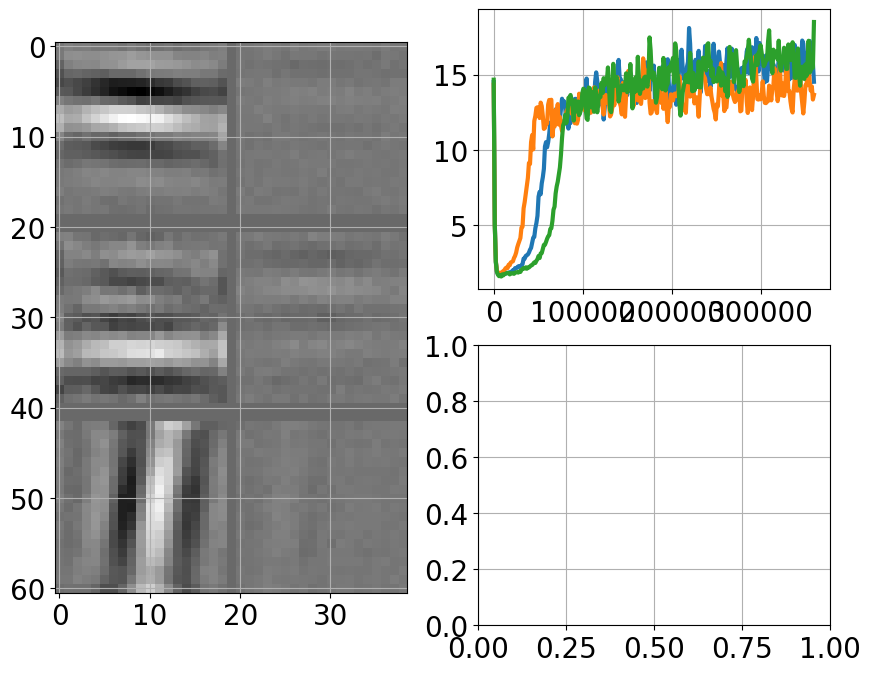

.] Sequence Time Elapsed...1 m, 20.01 s


In [38]:
deficit_base_sim=sfname

seq=pn.Sequence()

noise=0.3
patch_noise=1.0

seq+=patch_treatment_jitter(total_time=100*hour,
         save_interval=20*minute,number_of_neurons=number_of_neurons,
        mu_c=mu_c,sigma_c=sigma_c,
         eta=eta,
        noise=noise,patch_noise=patch_noise)
seq_load(seq,deficit_base_sim)    

seq.run(display=mydisplay,display_hash=False,
           time_between_display=save_interval)



(301, 3, 2)

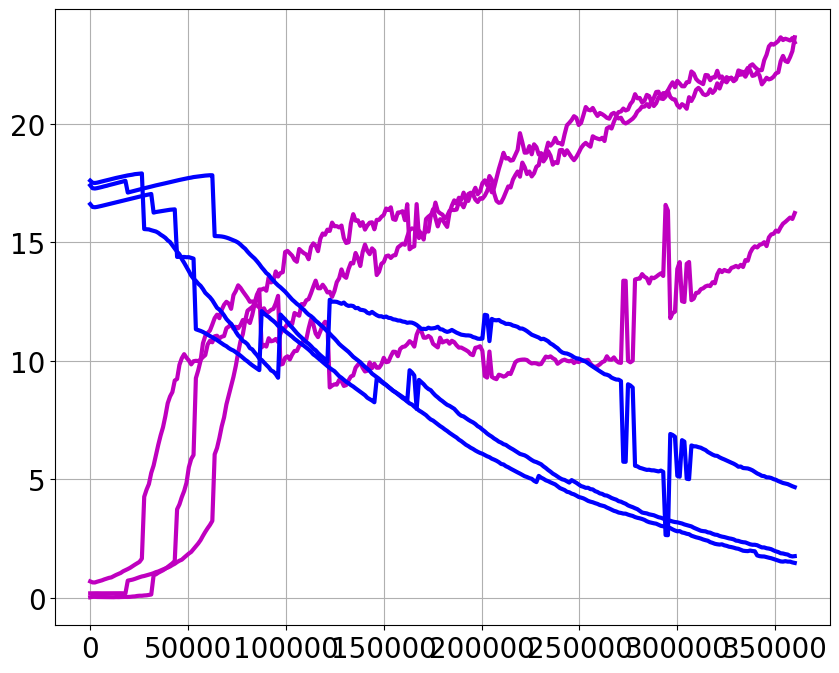

In [39]:
pp=seq[0][0].post_process[0]
t=pp.t
y=pn.utils.max_channel_response(pp.responses)
y=y.transpose([2,1,0]) 
plot(t,y[:,:,0],'m-')
plot(t,y[:,:,1],'b-')
y.shape
